In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from google.colab import files
from sklearn.preprocessing import StandardScaler

Add in the pre-processed dataset that we have to use for our PCA and clustering:

In [ ]:
#add the preprocessed datasets from my google drive
# from google.colab import drive
# drive.mount('/content/drive')

# train_df = pd.read_csv('/content/drive/MyDrive/train_df_doordash_pre_imp_scaling.csv')
# test_df = pd.read_csv('/content/drive/MyDrive/test_df_doordash_pre_imp_scaling.csv')

train_df = pd.read_csv('train_df_doordash_pre_imp_scaling.csv')
test_df = pd.read_csv('test_df_doordash_pre_imp_scaling.csv')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_df.head(5)

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,...,market_id_5,market_id_6,order_protocol_1,order_protocol_2,order_protocol_3,order_protocol_4,order_protocol_5,order_protocol_6,order_protocol_7,created_weekend
0,1,760,1,760,760,20.0,20.0,21.0,251,810.0,...,0,0,0,0,0,1,0,0,0,1
1,2,2266,1,856,949,54.0,40.0,64.0,251,525.0,...,0,0,0,1,0,0,0,0,0,0
2,5,3585,4,150,1295,22.0,14.0,22.0,251,216.0,...,1,0,0,0,0,0,1,0,0,0
3,1,1050,1,1050,1050,15.0,14.0,16.0,251,773.0,...,0,0,0,1,0,0,0,0,0,0
4,4,3635,3,450,1825,5.0,3.0,3.0,446,236.0,...,0,0,1,0,0,0,0,0,0,0


In [ ]:
test_df.head(5)

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,...,market_id_5,market_id_6,order_protocol_1,order_protocol_2,order_protocol_3,order_protocol_4,order_protocol_5,order_protocol_6,order_protocol_7,created_weekend
0,6,6235,6,495,1425,37.0,29.0,59.0,251,39.0,...,0,0,0,1,0,0,0,0,0,0
1,7,6150,5,500,1250,51.0,51.0,103.0,251,608.0,...,0,0,0,0,0,0,1,0,0,0
2,3,1790,3,500,650,42.0,43.0,63.0,251,847.0,...,0,0,0,0,0,1,0,0,0,1
3,1,1000,1,1000,1000,37.0,36.0,46.0,251,691.0,...,0,0,0,1,0,0,0,0,0,1
4,1,1200,1,1200,1200,NaN,NaN,NaN,251,682.0,...,0,1,0,1,0,0,0,0,0,0


In [ ]:
#download further packages and dependencies
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import StandardScaler

In [ ]:
#separate the features from the target
X_train = train_df.drop(columns=['slow_order', 'delivery_duration_min'])
y_train = train_df['slow_order']

X_test = test_df.drop(columns=['slow_order', 'delivery_duration_min'])
y_test = test_df['slow_order']

Now since the data we have is pre-imputation and pre-scaling, and to perform techniques such as PCA we need scaling, we can pre process the data that we have by using median imputation and standardizing the features.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Build preprocessing pipeline
preprocessing_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Fit on training data and transform both sets
X_train_scaled = preprocessing_pipeline.fit_transform(X_train)
X_test_scaled = preprocessing_pipeline.transform(X_test)

Now we proceed to PCA, where we first fit PCA with all components to analyze variance explained.

In [ ]:
# Fit PCA with all components
pca = PCA()
pca.fit(X_train_scaled)

# Extract singular values and calculate variance explained
singular_values = pca.singular_values_
variance_explained = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(variance_explained)

# Create variance explained dataframe
variance_df = pd.DataFrame({
  'PC': range(1, len(variance_explained) + 1),
  'Variance_Explained': variance_explained,
  'Cumulative_Variance': cumulative_variance
})

print("Top 15 Principal Components:")
print(variance_df.head(15))

# Find number of components for 80%, 90%, 95% variance
n_80 = np.argmax(cumulative_variance >= 0.80) + 1
n_90 = np.argmax(cumulative_variance >= 0.90) + 1
n_95 = np.argmax(cumulative_variance >= 0.95) + 1

print(f"\nComponents needed for 80% variance: {n_80}")
print(f"Components needed for 90% variance: {n_90}")
print(f"Components needed for 95% variance: {n_95}")

Top 15 Principal Components:
    PC  Variance_Explained  Cumulative_Variance
0    1            0.154733             0.154733
1    2            0.098999             0.253732
2    3            0.089836             0.343568
3    4            0.065708             0.409276
4    5            0.058979             0.468256
5    6            0.052970             0.521225
6    7            0.050342             0.571567
7    8            0.047884             0.619451
8    9            0.044587             0.664039
9   10            0.042598             0.706636
10  11            0.040640             0.747277
11  12            0.039386             0.786663
12  13            0.038409             0.825072
13  14            0.038290             0.863362
14  15            0.037279             0.900641

Components needed for 80% variance: 13
Components needed for 90% variance: 15
Components needed for 95% variance: 17


Next we visualize the variance explained by each principal component using a scree plot

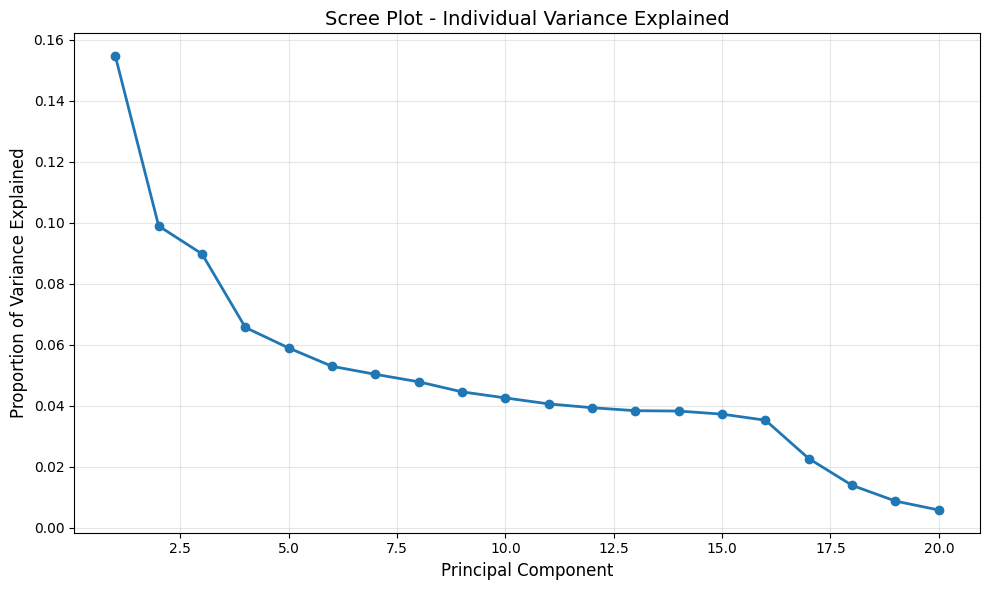

In [ ]:

#Variance explained per component (first 20 PCs)
plt.figure(figsize=(10, 6))
plt.plot(range(1, 21), variance_explained[:20], marker='o', linewidth=2)
plt.xlabel('Principal Component', fontsize=12)
plt.ylabel('Proportion of Variance Explained', fontsize=12)
plt.title('Scree Plot - Individual Variance Explained', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Apply PCA with 2 components
pca_2d = PCA(n_components=2)
X_train_pca_2d = pca_2d.fit_transform(X_train_scaled)
X_test_pca_2d = pca_2d.transform(X_test_scaled)


Now we move onto K-Means Clustering

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Test different values of k
k_values = range(2, 11)
inertias = []
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_train_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_train_scaled, kmeans.labels_))

# Store results in dataframe
elbow_df = pd.DataFrame({
    'k': k_values,
    'inertia': inertias,
    'silhouette_score': silhouette_scores
})

elbow_df

,k,inertia,silhouette_score
0,2,3.631821e+06,0.113271
1,3,3.350793e+06,0.118129
2,4,3.184326e+06,0.130356
3,5,3.046726e+06,0.128793
4,6,2.895748e+06,0.122951
5,7,2.794758e+06,0.132753
6,8,2.654683e+06,0.142123
7,9,2.535445e+06,0.133528
8,10,2.411337e+06,0.130138


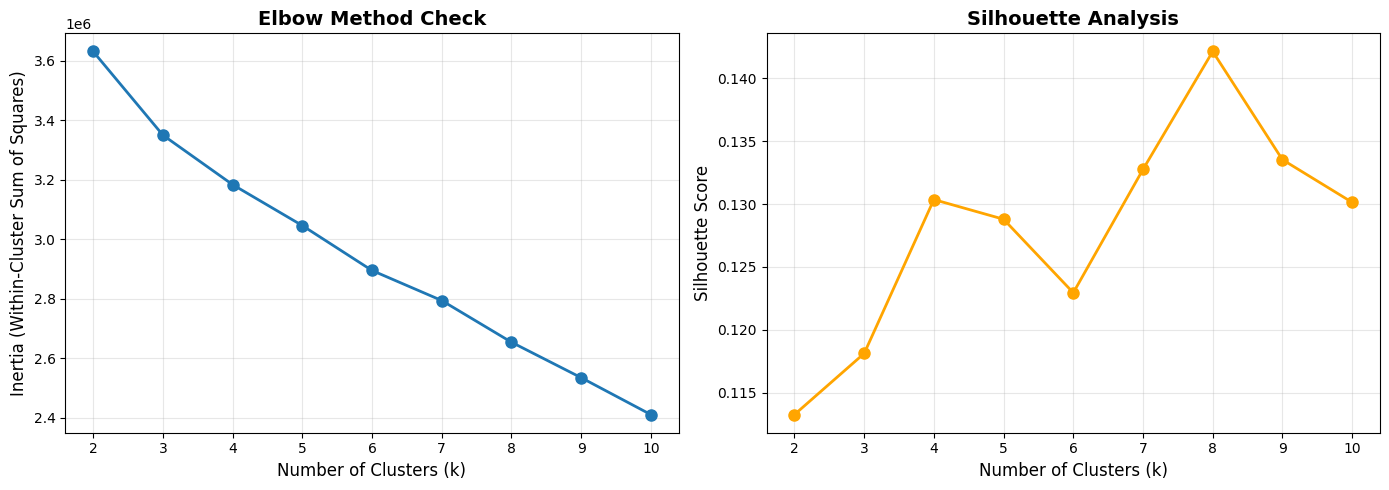

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Elbow plot
axes[0].plot(elbow_df['k'], elbow_df['inertia'], marker='o', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[0].set_ylabel('Inertia (Within-Cluster Sum of Squares)', fontsize=12)
axes[0].set_title('Elbow Method Check', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(elbow_df['k'])

# Silhouette score plot
axes[1].plot(elbow_df['k'], elbow_df['silhouette_score'], marker='o',
             linewidth=2, markersize=8, color='orange')
axes[1].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[1].set_ylabel('Silhouette Score', fontsize=12)
axes[1].set_title('Silhouette Analysis', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(elbow_df['k'])

plt.tight_layout()
plt.show()

We can choose the ideal value of our k hyperparameter to be k = 4 based on the table and the plots above.

In [ ]:
optimal_k = 4

# Fit final K-Means model on full training data
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
train_clusters = kmeans_final.fit_predict(X_train_scaled)
test_clusters = kmeans_final.predict(X_test_scaled)

# Add cluster labels to original dataframes
train_df_clustered = train_df.copy()
train_df_clustered['cluster'] = train_clusters

test_df_clustered = test_df.copy()
test_df_clustered['cluster'] = test_clusters

train_df_clustered['cluster'].value_counts().sort_index()

,count
cluster,
0,14311
1,64576
2,38662
3,39034


Finally we are going to examine the characteristics of each cluster that we got from our optimal k=4 hyperparameter value.

In [ ]:
# Select key features for interpretation
key_features = ['total_outstanding_orders', 'total_onshift_dashers',
                'total_busy_dashers', 'estimated_store_to_consumer_driving_duration',
                'estimated_order_place_duration', 'subtotal', 'created_hour',
                'slow_order']

# Calculate cluster statistics
cluster_summary = train_df_clustered.groupby('cluster')[key_features].mean()

cluster_summary

,total_outstanding_orders,total_onshift_dashers,total_busy_dashers,estimated_store_to_consumer_driving_duration,estimated_order_place_duration,subtotal,created_hour,slow_order
cluster,,,,,,,,
0,31.465435,27.092252,25.338153,513.971685,277.156383,1727.730347,10.739501,0.332192
1,34.458012,29.754767,28.362989,548.861121,253.875759,2483.988030,11.294273,0.265300
2,126.675525,90.126607,82.936166,562.733832,276.640500,3322.030780,2.640422,0.432285
3,30.636593,25.936571,24.231471,533.895588,442.268381,2721.809294,8.739765,0.372111


Before applying PCA and clustering, we implemented a preprocessing pipeline consisting of median imputation and standardization. Median imputation was used to handle any remaining missing values because the median is robust to outliers and appropriate for the skewed distributions. This approach was consistent with the preprocessing strategy used in our Linear Regression and Random Forest models. Standardization using StandardScaler was essential for both PCA and K-Means clustering because these algorithms are sensitive to feature scales. Without standardization, features with larger numeric ranges would dominate the principal components and distance calculations, leading to biased results.

We applied PCA to all features after removing the target variable (slow_order) and delivery_duration_min to prevent data leakage. The analysis revealed that the first principal component explained only 15.47% of the total variance, with every following component explaining smaller and smaller portions (9.90%, 8.98%, 6.57%, and 5.89% for PC2 through PC5). To capture 80% of cumulative variance, 13 principal components were required, while 90% variance required 15 components and 95% required 17 components. The scree plot demonstrated a gradual, steady decline in variance explained rather than a sharp elbow, indicating that no single dominant pattern exists in the data. This finding suggests that our features are diverse and non-redundant, which validates our decision to use all available features in the Random Forest classifier rather than applying dimensionality reduction. The relatively even distribution of variance across components explains why ensemble methods like Random Forest achieved strong performance (72.5% accuracy) compared to linear methods that struggle with high-dimensional data.

K-Means clustering was applied to the same standardized features to discover groupings in delivery characteristics. We evaluated cluster counts from k=2 to k=10 using both the elbow method (inertia) and silhouette analysis. The elbow plot showed a notable decrease in inertia from k=2 to k=4, with diminishing returns beyond k=4. Silhouette scores remained relatively stable across all k values, ranging from 0.113 to 0.142, indicating that variance is distributed across many dimensions. Based on interpretability and the elbow analysis, we selected k = 4 as the optimal hyperparameter for this situation.

Using k=4, the final K-Means model identified four distinct clusters. Cluster 0 (n=14,311) represented low to moderate demand scenarios with 31.5 average outstanding orders, 27.1 onshift dashers, and a 33.2% slow order rate. Cluster 1 (n=64,576) captures conditions with 34.5 outstanding orders, 29.8 onshift dashers, and the lowest slow rate at 28.5%, suggesting this represents periods where capacity closely matches demand. Cluster 2 (n=38,662) clearly identifies high-demand periods with 126.7 outstanding orders, 90.1 onshift dashers, 82.9 busy dashers, and the highest slow rate at 43.2%. Finally, Cluster 3 (n=39,03) shows lower demand with 30.6 outstanding orders, 25.9 onshift dashers, and a moderate slow rate of 37.2%.  The clustering analysis validates findings from our supervised learning models.

The features that drove cluster separation (total_outstanding_orders, total_onshift_dashers, total_busy_dashers) match precisely with the features Random Forest identified as most important through feature importance analysis. Additionally, the clear difference in slow_order rates across clusters demonstrates that unsupervised groupings align with our classification target, even though the clustering algorithm never saw the slow_order labels during training. Overall, between PCA and clustering, K-Means clustering proved more informative for this problem. PCA confirmed that our feature set is non-redundant and justified our full-feature modeling approach, but clustering delivered clearer insights.